# Applied ML Final Project

## Generation and Completion of Human Face Images

| Name                | ID         |
|---------------------|------------|
| Ananya Sinha        | MDS202307  |
| Ankita              | MDS202309  |
| Divyanshi Kumari    | MDS202322  |
| Rohit Roy           | MDS202340  |

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
torch.cuda.is_available()

True

### Generator

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, n_color=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.Tanh(),

            nn.Linear(512, 512 * 5 * 5),
            nn.BatchNorm1d(512 * 5 * 5),
            nn.Tanh(),
        )
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, n_color, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 512, 5, 5)
        return self.conv(x)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_color=3):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_color, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.Tanh(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.Tanh()
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 1024),  # adjust based on input size
            nn.Tanh(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

### Initializing them for training

In [ ]:
import torch.optim as optim
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Training function

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torchvision.utils import save_image

def train(X_train, batch_size, epochs=100):
    d_losses = []
    g_losses = []

    os.makedirs('./saved_models', exist_ok=True)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        np.random.shuffle(X_train)
        d_loss_epoch = []
        g_loss_epoch = []

        batch_iter = range(0, X_train.shape[0], batch_size)
        pbar = tqdm(batch_iter, desc=f"Epoch {epoch+1}", leave=False, position=1)

        for i in pbar:
            real_images = torch.tensor(X_train[i:i + batch_size]).float().to(device)
            real_labels = torch.ones(real_images.size(0), 1).to(device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(device)

            ### Train Discriminator ###
            noise = torch.rand(real_images.size(0), 100).uniform_(-1, 1).to(device)
            fake_images = G(noise)
            D_real = D(real_images)
            D_fake = D(fake_images.detach())
            d_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            ### Train Generator ###
            noise = torch.rand(real_images.size(0), 100).uniform_(-1, 1).to(device)
            fake_images = G(noise)
            D_fake = D(fake_images)
            g_loss = loss_fn(D_fake, real_labels)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            d_loss_val = d_loss.item()
            g_loss_val = g_loss.item()
            d_loss_epoch.append(d_loss_val)
            g_loss_epoch.append(g_loss_val)

            pbar.set_postfix({
                "D Loss": f"{d_loss_val:.4f}",
                "G Loss": f"{g_loss_val:.4f}"
            })

            # Saving samples to check the model stability
            # if i % 1000 == 0:
            #     sample = (fake_images[0].detach().cpu() + 1) / 2
            #     save_image(sample, f'samples/{epoch}_{i}.png')


        d_losses.append(np.mean(d_loss_epoch))
        g_losses.append(np.mean(g_loss_epoch))
        # np.savetxt("losses.txt", np.stack([d_losses, g_losses], axis=1), fmt='%.5f')

        # if (epoch + 1) % 3 == 0:
        torch.save(G.state_dict(), f'saved_models/generator_re_{epoch}.pt')
        torch.save(D.state_dict(), f'saved_models/discriminator_re_{epoch}.pt')

    # Plot losses after training
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Losses")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png")
    plt.show()


### Loading the preprocessed data

In [7]:
import pickle

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [8]:
X1 = load_pickle('celeba_data/pickle/000001_110331.pickle')
X2 = load_pickle('celeba_data/pickle/110332_202598.pickle')

In [9]:
X = np.concatenate((X1, X2), axis=0).astype(np.float32)
X = (X - 127.5) / 127.5
X = np.transpose(X, (0, 3, 1, 2))

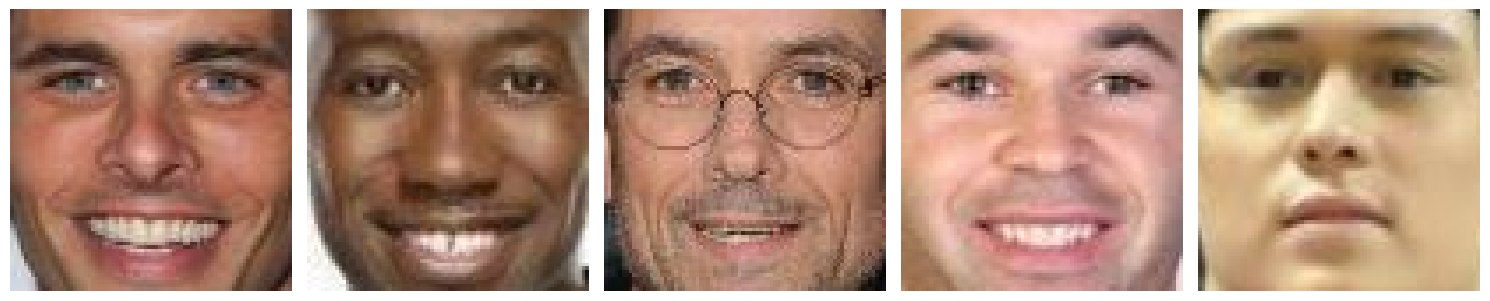

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random


def visualize_samples(X, num_samples=5):
    sample_indices = random.sample(range(X.shape[0]), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, idx in enumerate(sample_indices):
        image = X[idx] * 127.5 + 127.5  # Convert from [-1, 1] to [0, 255]
        image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        image = np.clip(image, 0, 255).astype(np.uint8)
        
        axes[i].imshow(image)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# visualize 5 sample images
visualize_samples(X, num_samples=5)


### Training process

Epochs: 100%|██████████| 100/100 [1:47:58<00:00, 64.79s/it]


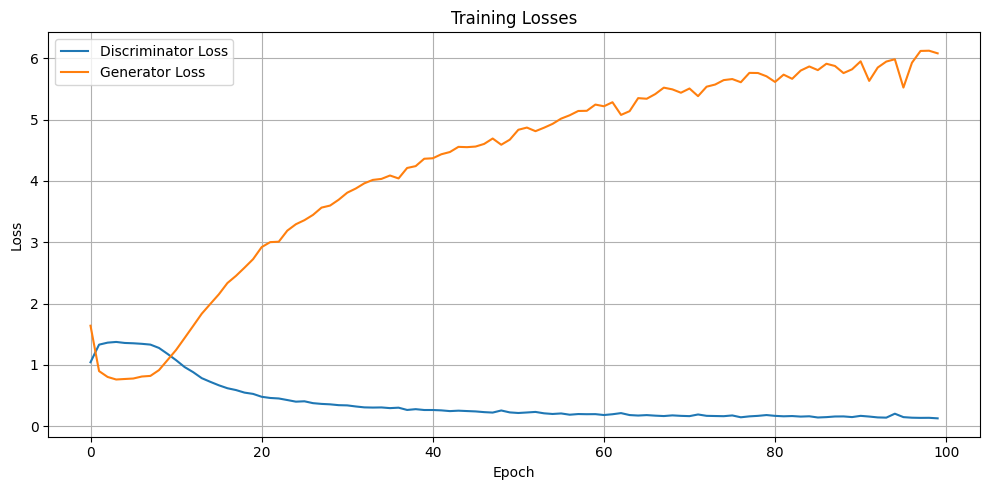

In [12]:
train(X, batch_size=100, epochs=100)

### Choosing the stable model

In [ ]:
G_use = Generator().to(device)
G_use.load_state_dict(torch.load("saved_models/generator_re_8.pt", map_location=device))
G_use.eval()

D_use = Discriminator().to(device)
D_use.load_state_dict(torch.load("saved_models/discriminator_re_8.pt", map_location=device))
D_use.eval()

/tmp/ipykernel_1903971/2935734036.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_use.load_state_dict(torch.load("generator_re_8.pt", map_location=device))
/tmp/ipyker

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): Tanh()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): Tanh()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=1024, bias=True)
    (2): Tanh()
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

## Testing the Model

### Defining image completion loss

In [ ]:
def image_completion_loss(gen_img, target_img, mask, discriminator, lambda_p=0.01):
    contextual = torch.abs(mask * (gen_img - target_img)).mean()
    perceptual = torch.log(1 - discriminator(gen_img)).mean()
    return contextual + lambda_p * perceptual

### Masking function

In [ ]:
def apply_mask(img, mask_size=30):
    masked = img.clone()
    h, w = img.shape[1:]
    top = (h - mask_size) // 2 + 17  # shift to lower part of face
    left = (w - mask_size) // 2
    mask = torch.ones_like(img)
    masked[:, top:top+mask_size, left:left+mask_size] = 0
    mask[:, top:top+mask_size, left:left+mask_size] = 0
    return masked, mask

### Image completion algorithm

In [ ]:
def complete_image(input_img, generator, discriminator, iters=500, lr=0.01, lambda_p=0.01):
    generator.eval()
    discriminator.eval()

    # Prepare target
    input_img = input_img.to(device)
    target_img = input_img.unsqueeze(0)  # [1, 3, 80, 80]
    masked_img, mask = apply_mask(input_img)
    mask = mask.unsqueeze(0).to(device)  # [1, 3, 80, 80]

    # Optimize latent vector
    z = torch.randn(1, 100, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([z], lr=lr)

    for _ in tqdm(range(iters)):
        gen_img = generator(z)
        loss = image_completion_loss(gen_img, target_img, mask, discriminator, lambda_p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        completed = target_img * mask + generator(z) * (1 - mask)
    
    return completed.squeeze(0)  # remove batch dimension

### Visualize results from the data

In [112]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_original_and_generated(X, G_use, D_use, indices=[0, 1, 2]):
    fig, axs = plt.subplots(len(indices), 2, figsize=(6, 3 * len(indices)))

    for i, idx in enumerate(indices):
        # Prepare the original image
        original = torch.tensor(X[idx]).float()
        original_vis = (original + 1) / 2  # assuming original in [-1,1]; if not, skip this line
        original_vis = original_vis.permute(1, 2, 0).numpy()

        # Generate the completed image
        # with torch.no_grad():
        completed = complete_image(original, G_use, D_use)
        completed_vis = (completed + 1) / 2
        # completed_vis.to_cpu()
        completed_vis = completed_vis.permute(1, 2, 0).cpu().numpy()

        # Plot original and completed
        axs[i, 0].imshow(original_vis)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(completed_vis)
        axs[i, 1].set_title("Generated")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
show_original_and_generated(X, G_use, D_use, indices=[0, 1, 2])

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_original_and_generated_random(X, G_use, D_use, num_samples=3):
    indices = np.random.choice(len(X), num_samples, replace=False)
    print(indices)
    fig, axs = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

    for i, idx in enumerate(indices):
        # Prepare the original image
        original = torch.tensor(X[idx]).float()
        original_vis = (original + 1) / 2  # scale to [0,1] if in [-1,1]
        original_vis = original_vis.permute(1, 2, 0).cpu().numpy()

        # Generate the completed image
        # with torch.no_grad():
        completed = complete_image(original.to('cuda'), G_use, D_use)
        completed_vis = (completed + 1) / 2
        completed_vis = completed_vis.permute(1, 2, 0).cpu().numpy()

        # Plot original and completed
        axs[i, 0].imshow(original_vis)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(completed_vis)
        axs[i, 1].set_title("Generated")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
show_original_and_generated_random(X, G_use, D_use, num_samples=5)